In [4]:
import numpy as np
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
import os
datadir = os.getcwd()
datafile = '/betaPic_mag_res.dat'

%matplotlib notebook

import emcee

In [5]:
times, mags = np.loadtxt(datadir + datafile, usecols=(0, 1)).T

In [6]:
#binning fuction
def bins(time, flux, binsize):
    n_bins = len(time) // binsize
    indexes = np.array_split(np.arange(len(time)), n_bins)
    print((indexes[0]).size)
    binned_time = np.array([np.mean(time[a]) for a in indexes])
    binned_flux = np.array([np.mean(flux[a]) for a in indexes])
    binned_flux_err = np.array([np.std(flux[a])/np.sqrt(a.size) for a in indexes])

    return (binned_time, binned_flux,binned_flux_err)

<Figure size 432x288 with 0 Axes>

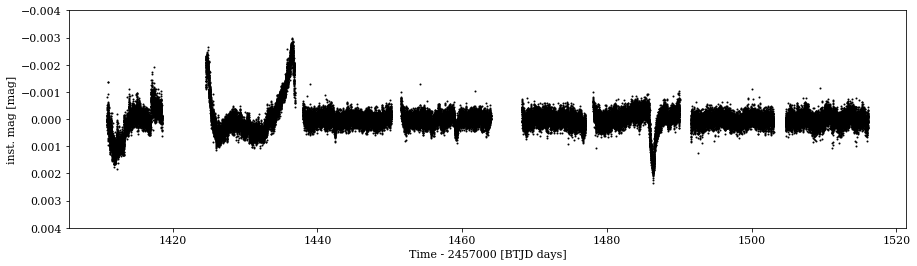

In [7]:
#plot reduced light curve from file
plt.rc('font', family='serif', size=11)
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

ax.scatter(times, mags, c='k', s=1)

ax.set_ylim(-0.004, 0.004)
ax.invert_yaxis()

ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('inst. mag [mag]')

plt.show()

16


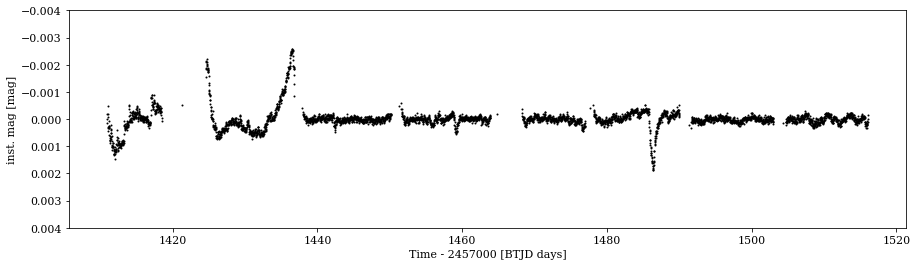

In [8]:
#plot binned (30 min) reduced light curve from file
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

#lets bin 15 points a 2 mins -> 30 min bins

(times_binned, mags_binned, mags_binned_error) = bins(times, mags, 15)

ax.scatter(times_binned, mags_binned, c='k', s=1)

ax.set_ylim(-0.004, 0.004)
ax.invert_yaxis()

ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('inst. mag [mag]')

plt.show()

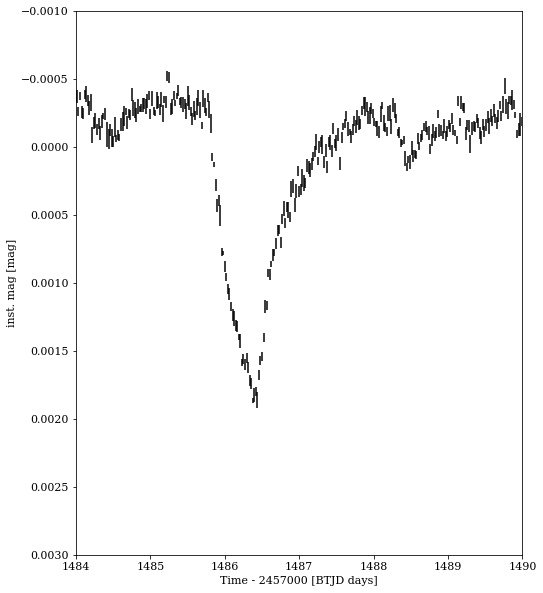

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.errorbar(times_binned, mags_binned, yerr=mags_binned_error, c='k',fmt='none')

ax.set_ylim(-0.001, 0.003)
ax.set_xlim(1484., 1490)
ax.invert_yaxis()

ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('inst. mag [mag]')

plt.show()

## Parameters of Beta Pictoris

In [10]:
Rs = 1.53 * c.R_sun # Wang 2016
Ms = 1.80 * c.M_sun # Wang 2016

Pmin = 4 * (1512. - 1411.) * u.day
print(Pmin)

404.0 d


## Orbital dynamics


In [11]:
@u.quantity_input
def vcirc(m1:u.Msun,m2:u.Mjup,a:u.au)->u.km/u.s:
    """
    Circular orbital velocity of m2 about m1 at distance a

    Args:
        m1, m2: Primary and secondary masses
        a: semimajor axis

    Returns:
        velocity: circular orbital velocity

    >>> import astropy.units as u
    >>> vcirc(1.0 *u.M_sun, 1.0 * u.M_jup, 5.2 * u.au)
    <Quantity 13.06768412 km / s>
    """
    mu = c.G * (m1 + m2)
    vcirc = np.power(mu/a, 0.5)
    return vcirc


@u.quantity_input
def Ptoa(P:u.year, m1:u.M_sun, m2:u.M_jup)->u.au:
    """calculate orbital radius from period

    Args:
        P: orbital period
        m1, m2: Primary and secondary masses

    Returns:
        a: semi-major axis

    >>> import astropy.units as u
    >>> Ptoa(11.86*u.year, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 5.20222482 AU>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)
    const = c.G / (4.*np.pi*np.pi)
    mu = m1 + m2
    a3 = P*P*const*mu
    aa = np.power(a3, 1./3.)
    
    return aa


## Calculate max velocity, minimum semimajor axis

Given that there's no other big eclipse, we can determine a minimum orbital period, and from that the orbital radius and largest circular velocity

In [12]:
amin = Ptoa(Pmin, Ms, 0.0 * c.M_sun)

print(amin)

1.3010064823943785 AU


In [13]:
vc = vcirc(Ms, 0.0*c.M_sun, amin)
print(vc)

35.03399255119653 km / s


In [14]:
t_star = (Rs / vc).to(u.day)
print(t_star)

0.3516495438536376 d


## Subroutines derived from Brogi 2012

In [15]:
def rc_hat(rc, a):
    'angular size of chord on star as seen from distance a'
    return np.arcsin(rc/(2*a))

def disk_intensity(thetad, rchat, a, Rstar, ulimb=0.79):
    'stellar disk intensity collapsed to 1D'
    s1 = np.power(np.sin(rchat/2),2) - np.power(np.sin(thetad),2)
    s1_negative = (s1<0)
    s1[s1_negative] = 0. # to prevent error with sqrt below
    s2 = 1 - (a/Rstar)*np.sqrt(s1)
    res = 1-(ulimb*s2)
    res[s1_negative] = 0
    return res

# make an exponential decay absorption for a comet tail
def rho(dtheta,ce,lam):
    'extinction cross section for comet'
    rho = ce * np.exp(-lam*dtheta)
    rho[(dtheta<0)] = 0 # no dust in front of the comet
    return rho

def impact_param(rc, Rstar):
    'impact parameter for a star and orbit around the star'
    d1 = rc/(2*Rstar)
    d2 = 1 - np.power(d1,2.)
    return np.sqrt(d2)

def rchordit(b, Rstar):
    'chord length for b'
    # b2 + (rc/2R)2 = 1
    # rc/2R = sqrt(1-b2)
    d1 = np.sqrt(1.-b*b)
    return d1*2*Rstar

## Select light curve points and initial guess for the fit

### convert mags to flux
$ m_a - m_b = -2.5\log(I_a/I_b)$

In [16]:
tmid = 1486.5 * u.day

tmin = 1485.0
tmax = 1488.0

m_zero = -0.0003 # estimate for no comet magnitude of star

tmask = (times_binned>tmin) * (times_binned<tmax)
t = times_binned[tmask]
f = np.power(10,(mags_binned[tmask]-m_zero)/-2.5)
ferr = mags_binned_error[tmask]

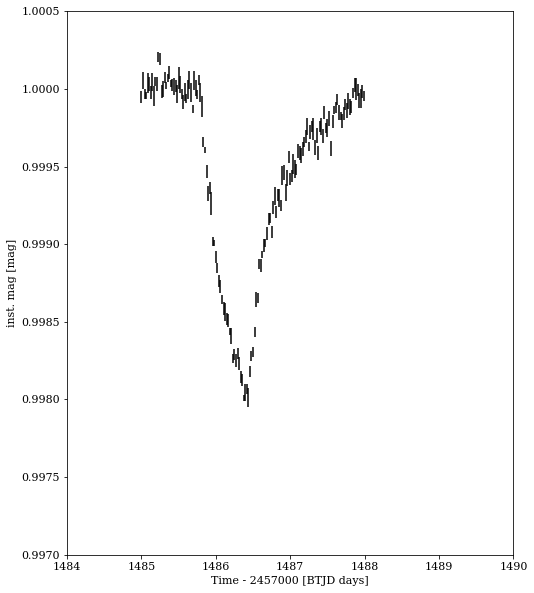

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.errorbar(t, f, yerr=ferr, c='k',fmt='none')
ax.set_ylim(0.9970, 1.0005)
ax.set_xlim(1484., 1490)

ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('inst. mag [mag]')

plt.show()

## Exocomet model

In [18]:
def modelexo(t, y, yerr, tmid, bimpact, cmax, lam, P, Mstar, Rstar, ulimb):
    
    # convert time to orbital phase angle
    t_phase = (2*np.pi* (t - tmid) / P) * u.radian

    # convert period to semimajor axis
    a = Ptoa(P, Mstar, 0.0 * c.M_sun)

    # calculate size of a chord across the star
    rc = rchordit(bimpact, Rstar)
    
    # calculate angular size of chord across the star
    rchat = rc_hat(rc,a)
    
    # calculate intensity profile
    I = disk_intensity(t_phase, rchat, a, Rstar, ulimb)
    Inorm = I / I.sum()
   
    # calculate comet tail
    rh = rho(t_phase, cmax, lam)
    
    # convolve two curves together to get 
    Itot = np.convolve(Inorm, rh,'same')

    return 1-Itot

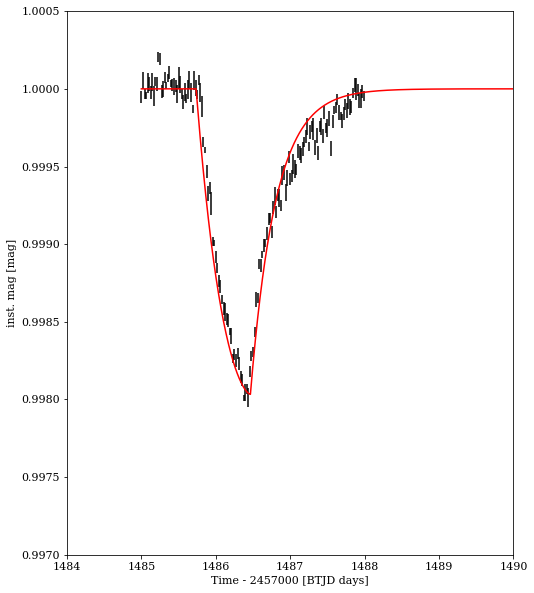

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.errorbar(t, f, yerr=ferr, c='k',fmt='none')
ax.set_ylim(0.9970, 1.0005)
ax.set_xlim(1484., 1490)

ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('inst. mag [mag]')

#rchord = 2 * Rs
impact = 0.
tmodel = np.linspace(1485, 1490, 2000)
I_model = modelexo(tmodel * u.day, f, ferr, tmid+0.3*u.day, impact, 0.0048, 1700/u.radian, Pmin*9, Ms, Rs, 0.275)

ax.plot(tmodel, I_model, c='r')



plt.show()

In [147]:
tmid = 1486.3 * u.day

In [148]:
def modelexi(tin, y, yerr, tmid, bimpact, cmax, lam, P, Mstar, Rstar, ulimb):

    tinmin = tin.min()
    tinmax = tin.max()
    tdelt = tinmax - tinmin
    
    # make a wider range of regularly spaced times so that convolution doesn't have round off error
    t_model = np.linspace(tinmin-tdelt, tinmax+tdelt, 501)
    
    # convert time to orbital phase angle
    t_phase = (2*np.pi* (t_model - tmid) / P) * u.radian

    # convert period to semimajor axis
    a = Ptoa(P, Mstar, 0.0 * c.M_sun)

    # calculate size of a chord across the star
    rc = rchordit(bimpact, Rstar)
    
    # calculate angular size of chord across the star
    rchat = rc_hat(rc,a)
    
    # calculate intensity profile for a chord across the star
    I = disk_intensity(t_phase, rchat, a, Rstar, ulimb)
    Inorm = I / I.sum()
   
    # calculate comet tail
    rh = rho(t_phase, cmax, lam)
    
    # convolve two curves together to get 
    Itot = np.convolve(Inorm, rh,'same')
    
    # now use linear interpolator to find values of Itot at the t_inp times
    Itot_tin = np.interp(tin, t_model, Itot)

    return 1 - Itot_tin



3636.0 d
1486.3 d
0.0


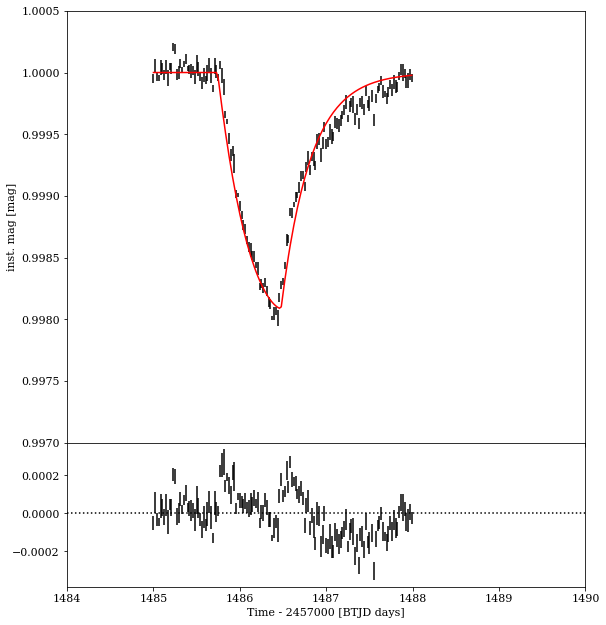

In [149]:
print(Pmin*9)
print(tmid)
print(impact)
#                      x       y . yerr [tmid, b,   ca,     ,lammy, period], const,  const,  const
I_model2 = modelexi(t * u.day, f, ferr, tmid, impact, 0.0048, 1700/u.radian, 3636.*u.day, Ms, Rs, 0.275)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

ax1.errorbar(t, f, yerr=ferr, c='k',fmt='none')
ax1.set_ylim(0.9970, 1.0005)
ax1.set_xlim(1484., 1490)
ax2.set_position([0.1,0.1, 0.9, 0.2])
ax1.set_position([0.1,0.3, 0.9, 0.6])

ax2.set_xlabel('Time - 2457000 [BTJD days]')
ax1.set_ylabel('inst. mag [mag]')

ax1.plot(t, I_model2, c='r')
ax2.errorbar(t, f-I_model2, yerr=ferr, c='k', fmt='none')
ax2.axhline(y=0, color='k', linestyle='dotted')

plt.show()

In [158]:
ce = 0.0045
lamb = 1700.
period = 3636.

def lnlike(theta, t, f, ferr):
    tmid, impact, ce, lamb, period = theta
    model = modelexi(t*u.day, f, ferr, tmid*u.day, impact, ce, lamb/u.radian, period*u.day, Ms, Rs, 0.275)
    chi2 = np.power((f-model)/ferr,2.)
    print(chi2)
    return -0.5*(np.sum(chi2))

In [166]:
import scipy.optimize as op

#lnlike([1486.3, 0.0, 0.0045, 1700., 3636.], t, f, ferr)

nll = lambda *args: -lnlike(*args)
#result = op.minimize(nll, [1486.3, 0.0, 0.0045, 1700., 3636.], method='nelder-mead', args=(t,f,ferr),options={'maxiter':10000,'xtol': 1e-8, 'disp': True})

result = op.minimize(nll, [1.48629851e+03, 1.36211126e-02, 4.15753435e-03, 1.01953671e+03, 2.50062804e+03], method='nelder-mead', args=(t,f,ferr),options={'maxiter':10000,'xtol': 1e-8, 'disp': True})


result

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 1.26774543e-01 6.28937529e-02
 1.78718616e+01 1.08857169e+01 5.15725372e+00 7.55631746e+00
 4.82365425e-04 5.95113195e-03 3.08511744e+01 2.04509870e+01
 4.92445823e+00 7.02574065e+00 4.92670555e+00 1.22025321e+00
 4.41008616e+00 1.71040236e+00 9.43452037e-02 3.29248498e-02
 9.08438599e-01 1.04072250e+00 6.67436838e-01 4.45732613e+00
 1.21316903e-01 1.26465144e-01 6.96516960e+00 2.80275007e+00
 5.10888370e-02 2.310142

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.88506139e-01 1.12398867e+00
 2.32074382e+00 9.07995676e-02 5.02942307e-01 2.19401135e+00
 2.07123562e+00 3.25938893e-01 1.63078020e+01 5.69731707e+00
 1.90815902e+00 2.86919275e+00 2.56403080e+00 4.10912338e-01
 2.56042025e+00 1.08229017e+00 2.86300686e-02 4.01536223e-03
 9.65936124e-01 8.86441472e-01 5.29094273e-01 5.70377581e+00
 6.74883342e-03 3.64847201e-03 5.00833377e+00 1.57318059e+00
 6.28229750e-02 2.321139

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 1.26774543e-01 2.94330416e+00
 6.04187057e+01 7.30464379e+01 2.29198038e+01 2.50632765e+01
 7.69098025e+00 2.24565913e+00 8.59655964e+01 1.08558952e+02
 2.35338885e+01 3.74045217e+01 2.34958910e+01 1.20556005e+01
 2.77954933e+01 1.24476020e+01 3.78303729e+00 6.78281175e+00
 1.40248145e+00 8.03438771e+00 6.98092967e-01 2.78279122e+01
 3.44387612e+00 2.43835331e+00 2.48925417e-01 4.90902906e-02
 2.66638965e+00 1.757255

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.86342687e-01 1.11969635e+00
 2.34123432e+00 8.27279910e-02 5.15465646e-01 2.22430824e+00
 2.02569738e+00 3.14655809e-01 1.65635580e+01 5.98515103e+00
 1.99527317e+00 3.03258952e+00 2.69815955e+00 4.66961856e-01
 2.76906163e+00 1.18900862e+00 4.42311428e-02 1.70742517e-02
 8.41657987e-01 6.59504705e-01 4.44520553e-01 6.32480970e+00
 1.91665844e-04 9.17581460e-04 4.52866940e+00 1.31950431e+00
 1.31795548e-01 2.790175

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.88625606e-01 1.13054503e+00
 2.27669862e+00 1.10262973e-01 4.77144914e-01 2.13749798e+00
 2.14768471e+00 3.42476733e-01 1.59958834e+01 5.40383730e+00
 1.83289232e+00 2.75159947e+00 2.48413050e+00 3.84619688e-01
 2.48161270e+00 1.05188747e+00 2.58034791e-02 2.97618414e-03
 9.73688750e-01 8.85299173e-01 5.23413668e-01 5.77667391e+00
 4.31229725e-03 1.63728962e-03 4.87886842e+00 1.49277387e+00
 8.39654530e-02 8.871359

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.88105837e-01 1.12962653e+00
 2.28029397e+00 1.08927388e-01 4.78645891e-01 2.14065159e+00
 2.14339769e+00 3.41529685e-01 1.60142126e+01 5.42204475e+00
 1.83796898e+00 2.76035844e+00 2.49086126e+00 3.87162130e-01
 2.49080040e+00 1.05633046e+00 2.63498154e-02 3.27235144e-03
 9.68812103e-01 8.76437465e-01 5.20319700e-01 5.79755612e+00
 3.90188504e-03 1.40687258e-03 4.86339400e+00 1.48470099e+00
 8.59878914e-02 9.567546

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.86783764e-01 1.12736074e+00
 2.28898021e+00 1.05785883e-01 4.82186164e-01 2.14802858e+00
 2.13344275e+00 3.39337751e-01 1.60567220e+01 5.46434297e+00
 1.84976415e+00 2.78074050e+00 2.50654311e+00 3.93116361e-01
 2.51231266e+00 1.06676210e+00 2.76535470e-02 4.02390446e-03
 9.57369621e-01 8.55686403e-01 5.13033880e-01 5.84722489e+00
 3.00921854e-03 9.28891029e-04 4.82663205e+00 1.46554187e+00
 9.09093395e-02 1.133419

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.72372047e-01 1.10781029e+00
 2.34901549e+00 8.92131840e-02 4.98369199e-01 2.17560648e+00
 2.10291000e+00 3.33746629e-01 1.61484075e+01 5.54184311e+00
 1.86823408e+00 2.80843513e+00 2.52532403e+00 3.99561851e-01
 2.53369516e+00 1.07656954e+00 2.88624008e-02 4.76527723e-03
 9.47026949e-01 8.36486684e-01 5.05955659e-01 5.89886186e+00
 2.15817533e-03 4.90669102e-04 4.77993115e+00 1.43932968e+00
 9.85179527e-02 1.452692

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 1.26774543e-01 6.17745528e-02
 1.77850576e+01 1.07450279e+01 5.09971802e+00 7.48409671e+00
 1.59843475e-03 4.53462221e-03 3.05551735e+01 2.00622124e+01
 4.83922247e+00 6.89403488e+00 4.84591605e+00 1.18604483e+00
 4.32920974e+00 1.67864565e+00 8.95952275e-02 2.95310187e-02
 9.20880710e-01 1.05665588e+00 6.69833140e-01 4.46207624e+00
 1.18709011e-01 1.22170287e-01 6.91134962e+00 2.76156626e+00
 4.42600568e-02 2.130904

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.60861916e-01 1.08756279e+00
 2.43177858e+00 6.42981479e-02 5.32699288e-01 2.24449549e+00
 2.01552298e+00 3.15289927e-01 1.65021091e+01 5.88102886e+00
 1.95698294e+00 2.95248929e+00 2.62831583e+00 4.36535067e-01
 2.65487674e+00 1.13045564e+00 3.54112467e-02 9.01894864e-03
 9.05194758e-01 7.70423524e-01 4.85287878e-01 6.02451389e+00
 9.20321544e-04 9.66961524e-05 4.72892355e+00 1.41925066e+00
 1.02421875e-01 1.545791

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.62370132e-01 1.09155771e+00
 2.41143410e+00 7.07103558e-02 5.22485299e-01 2.22308191e+00
 2.04335439e+00 3.21322545e-01 1.63823583e+01 5.76343133e+00
 1.92583486e+00 2.90130260e+00 2.59142450e+00 4.23084232e-01
 2.61081608e+00 1.11077086e+00 3.29533998e-02 7.31541590e-03
 9.20293118e-01 7.94045635e-01 4.92677141e-01 5.97964531e+00
 1.29390620e-03 1.96460266e-04 4.74540243e+00 1.42518807e+00
 1.01461590e-01 1.534801

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 1.45533074e+01 6.77544154e+00 7.41609363e+00
 5.66800139e+00 3.85186009e+01 4.84239729e+00 1.45455320e+00
 2.36906037e+01 5.60326404e+00 6.41866527e-01 3.04587454e+01
 5.06764493e+00 1.04140013e+01 5.00215839e+00 8.49138236e+00
 1.08583926e+01 6.14996730e+00 6.24022797e+00 1.59106920e+01
 2.16558987e+01 5.99039059e+01 1.38432009e+01 1.22465206e+01
 1.84706098e+01 1.46826638e+01 4.31974762e+01 2.71667182e+01
 1.41208406e+01 1.588349

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.57514716e-01 1.08475136e+00
 2.43480413e+00 6.49721961e-02 5.30062480e-01 2.23682334e+00
 2.02750991e+00 3.18235864e-01 1.64377057e+01 5.81281190e+00
 1.93775316e+00 2.91908372e+00 2.60299072e+00 4.26833074e-01
 2.62159628e+00 1.11486529e+00 3.33624739e-02 7.51821664e-03
 9.19167489e-01 7.93691095e-01 4.93101958e-01 5.97299655e+00
 1.40545842e-03 2.51530995e-04 4.75705250e+00 1.43222280e+00
 9.92529654e-02 1.436988

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 1.15244271e+00 2.06562041e+00
 6.91800628e-02 7.28168688e+00 4.69510611e-01 3.22165546e-04
 1.22990481e+01 3.06135303e+00 3.96804876e-01 1.24414954e+01
 2.19601634e+00 5.60200069e+00 2.87854828e+00 6.38157574e+00
 8.43525934e+00 5.26417640e+00 5.88073449e+00 1.57917774e+01
 2.22934776e+01 6.41216418e+01 1.51890156e+01 1.56468044e+01
 2.20705970e+01 1.80826242e+01 5.07563342e+01 3.33614077e+01
 1.92459184e+01 2.185828

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.55011650e-01 1.07845236e+00
 2.46658336e+00 5.56443737e-02 5.45871351e-01 2.26970184e+00
 1.98526948e+00 3.09102158e-01 1.66207974e+01 5.99342228e+00
 1.98554101e+00 2.99770965e+00 2.65966863e+00 4.47629107e-01
 2.68959348e+00 1.14533390e+00 3.72257280e-02 1.02777102e-02
 8.95626226e-01 7.56638851e-01 4.81363270e-01 6.04540860e+00
 7.97039978e-04 7.74049910e-05 4.72801031e+00 1.42093522e+00
 1.01382517e-01 1.482910

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54526592e-01 1.07759708e+00
 2.47020288e+00 5.47251394e-02 5.47412867e-01 2.27275702e+00
 1.98151110e+00 3.08313061e-01 1.66364255e+01 6.00860683e+00
 1.98947716e+00 3.00407427e+00 2.66416993e+00 4.49262560e-01
 2.69480433e+00 1.14762293e+00 3.75157958e-02 1.04903448e-02
 8.94012287e-01 7.54202228e-01 4.80620363e-01 6.04977226e+00
 7.68351616e-04 7.14326218e-05 4.72685613e+00 1.42065302e+00
 1.01376824e-01 1.479439

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54432335e-01 1.07750599e+00
 2.47037843e+00 5.47134307e-02 5.47394795e-01 2.27266575e+00
 1.98167681e+00 3.08357099e-01 1.66353962e+01 6.00747110e+00
 1.98915036e+00 3.00349571e+00 2.66372585e+00 4.49088442e-01
 2.69420606e+00 1.14733971e+00 3.74769755e-02 1.04593699e-02
 8.94268231e-01 7.54629509e-01 4.80766864e-01 6.04878096e+00
 7.76084707e-04 7.34643446e-05 4.72742460e+00 1.42092246e+00
 1.01308325e-01 1.476986

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 1.41653607e+01 6.39194736e+00 6.82031033e+00
 4.14584707e+00 3.10585107e+01 3.38017711e+00 6.88534587e-01
 1.88222473e+01 4.27071233e+00 4.43341606e-03 1.61123156e+01
 2.31791273e+00 4.80957261e+00 1.94893954e+00 4.43468264e+00
 4.59794305e+00 2.64560646e+00 3.35992842e+00 8.71378976e+00
 1.36262869e+01 3.50134880e+01 8.41620748e+00 3.44094899e+00
 9.59593635e+00 7.49930140e+00 2.80211104e+01 1.61915110e+01
 6.41742072e+00 7.458808

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54438136e-01 1.07756345e+00
 2.47000256e+00 5.48291824e-02 5.47175805e-01 2.27219640e+00
 1.98228831e+00 3.08491481e-01 1.66326305e+01 6.00469348e+00
 1.98840867e+00 3.00226242e+00 2.66282972e+00 4.48754215e-01
 2.69310995e+00 1.14684376e+00 3.74120228e-02 1.04099340e-02
 8.94658364e-01 7.55248265e-01 4.80967378e-01 6.04750738e+00
 7.85378521e-04 7.57271165e-05 4.72798708e+00 1.42115622e+00
 1.01258502e-01 1.475606

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54915293e-01 1.07879558e+00
 2.46369541e+00 5.66114298e-02 5.44006588e-01 2.26562128e+00
 1.99066959e+00 3.10300802e-01 1.65960215e+01 5.96842965e+00
 1.97883234e+00 2.98650952e+00 2.65149725e+00 4.44576255e-01
 2.67953464e+00 1.14076876e+00 3.66290909e-02 9.82747017e-03
 8.99264817e-01 7.62438909e-01 4.83247665e-01 6.03340953e+00
 8.88565288e-04 1.00980484e-04 4.73343273e+00 1.42321788e+00
 1.00886967e-01 1.468696

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54940466e-01 1.07886478e+00
 2.46333348e+00 5.67157075e-02 5.43821878e-01 2.26523618e+00
 1.99116293e+00 3.10407615e-01 1.65938603e+01 5.96628687e+00
 1.97826528e+00 2.98557518e+00 2.65082373e+00 4.44327825e-01
 2.67872493e+00 1.14040567e+00 3.65823833e-02 9.79296714e-03
 8.99543155e-01 7.62875503e-01 4.83386569e-01 6.03254745e+00
 8.95134861e-04 1.02673484e-04 4.73377726e+00 1.42335164e+00
 1.00861681e-01 1.468154

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54878161e-01 1.07870490e+00
 2.46414914e+00 5.64835233e-02 5.44230648e-01 2.26608445e+00
 1.99008014e+00 3.10173842e-01 1.65985797e+01 5.97095618e+00
 1.97949841e+00 2.98760298e+00 2.65228252e+00 4.44864832e-01
 2.68047121e+00 1.14118686e+00 3.66826339e-02 9.86684458e-03
 8.98949929e-01 7.61948955e-01 4.83093272e-01 6.03435614e+00
 8.81496523e-04 9.92084163e-05 4.73308129e+00 1.42308911e+00
 1.00908577e-01 1.469005

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 1.41688602e+01 6.39534607e+00 6.82540802e+00
 4.15764856e+00 3.11154227e+01 3.39045405e+00 6.93146062e-01
 1.88545390e+01 4.27903883e+00 3.72839591e-03 1.61852981e+01
 2.33059555e+00 4.83403973e+00 1.96086209e+00 4.45090605e+00
 4.61995893e+00 2.65714429e+00 3.36932856e+00 8.73558971e+00
 1.36495199e+01 3.50778685e+01 8.42905868e+00 3.45574402e+00
 9.61190366e+00 7.51052947e+00 2.80428431e+01 1.62043015e+01
 6.42406821e+00 7.464326

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 1.41687726e+01 6.39526261e+00 6.82528396e+00
 4.15736231e+00 3.11140456e+01 3.39020567e+00 6.93034621e-01
 1.88537602e+01 4.27883813e+00 3.74465638e-03 1.61835394e+01
 2.33028999e+00 4.83345053e+00 1.96057501e+00 4.45051578e+00
 4.61942934e+00 2.65686688e+00 3.36910271e+00 8.73506618e+00
 1.36489623e+01 3.50763240e+01 8.42875057e+00 3.45538929e+00
 9.61152136e+00 7.51026091e+00 2.80423240e+01 1.62039965e+01
 6.42391008e+00 7.464195

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 1.41688073e+01 6.39529581e+00 6.82533335e+00
 4.15747631e+00 3.11145941e+01 3.39030462e+00 6.93079020e-01
 1.88540705e+01 4.27891810e+00 3.73817269e-03 1.61842402e+01
 2.33041176e+00 4.83368533e+00 1.96068941e+00 4.45067131e+00
 4.61964039e+00 2.65697744e+00 3.36919272e+00 8.73527482e+00
 1.36491845e+01 3.50769395e+01 8.42887336e+00 3.45553066e+00
 9.61167372e+00 7.51036794e+00 2.80425308e+01 1.62041180e+01
 6.42397309e+00 7.464247

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54876363e-01 1.07870354e+00
 2.46414985e+00 5.64841424e-02 5.44228710e-01 2.26607926e+00
 1.99008787e+00 3.10175696e-01 1.65985392e+01 5.97091348e+00
 1.97948651e+00 2.98758244e+00 2.65226708e+00 4.44858900e-01
 2.68045110e+00 1.14117748e+00 3.66813753e-02 9.86587167e-03
 8.98958132e-01 7.61962511e-01 4.83097850e-01 6.03432568e+00
 8.81747193e-04 9.92794794e-05 4.73309801e+00 1.42309688e+00
 1.00906648e-01 1.468937

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54876188e-01 1.07870336e+00
 2.46415022e+00 5.64841072e-02 5.44228704e-01 2.26607915e+00
 1.99008808e+00 3.10175756e-01 1.65985378e+01 5.97091193e+00
 1.97948606e+00 2.98758167e+00 2.65226649e+00 4.44858675e-01
 2.68045034e+00 1.14117713e+00 3.66813293e-02 9.86583693e-03
 8.98958416e-01 7.61962964e-01 4.83097996e-01 6.03432476e+00
 8.81754223e-04 9.92812954e-05 4.73309839e+00 1.42309703e+00
 1.00906620e-01 1.468937

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54876402e-01 1.07870364e+00
 2.46414933e+00 5.64842933e-02 5.44228443e-01 2.26607870e+00
 1.99008857e+00 3.10175849e-01 1.65985361e+01 5.97091042e+00
 1.97948570e+00 2.98758111e+00 2.65226612e+00 4.44858547e-01
 2.68044995e+00 1.14117696e+00 3.66813092e-02 9.86582287e-03
 8.98958523e-01 7.61963123e-01 4.83098044e-01 6.03432448e+00
 8.81756221e-04 9.92817701e-05 4.73309848e+00 1.42309706e+00
 1.00906615e-01 1.468937

[1.92168791e+00 9.98393462e-01 9.25083602e-01 4.15827496e+00
 3.82537858e-01 4.48771868e-01 2.55627709e-01 6.16071068e-01
 5.28159050e-01 2.68025944e+00 4.35356727e-01 3.63646558e+01
 2.33867567e+01 1.58567651e-01 2.92860496e-06 4.57819144e+00
 7.83584204e-01 7.96715999e+00 6.64184944e+00 1.97269400e+00
 3.98001405e-01 5.50982911e-02 1.83153477e-01 3.52186289e-01
 9.71568894e-01 2.63558230e-01 9.86384345e-01 3.49079380e+00
 1.00247827e-01 3.88609072e+00 2.85877721e-03 9.85254595e-01
 1.39339543e-01 2.33091960e+01 7.09899054e-01 1.33123534e-02
 1.74776278e+00 3.23444301e+00 7.54876191e-01 1.07870337e+00
 2.46415018e+00 5.64841180e-02 5.44228684e-01 2.26607911e+00
 1.99008813e+00 3.10175767e-01 1.65985376e+01 5.97091171e+00
 1.97948601e+00 2.98758157e+00 2.65226642e+00 4.44858650e-01
 2.68045026e+00 1.14117709e+00 3.66813245e-02 9.86583342e-03
 8.98958444e-01 7.61963008e-01 4.83098010e-01 6.03432467e+00
 8.81754874e-04 9.92814604e-05 4.73309842e+00 1.42309704e+00
 1.00906617e-01 1.468937

 final_simplex: (array([[1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03]]), array([338.88041305, 338.88041305, 338.88041305, 338.88041809,
       338.88041809, 338.88041809]))
           fun: 338.88041305110016
       message: 'Optimization terminated successfully.'
          nfev: 917
           nit: 440
        status: 0
       success: True
             x: array([1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
       2.50069581e+03])

In [177]:
def plotfit(theta, t, f, ferr):
    tmid, impact, ce, lamb, period = theta
    model = modelexi(t*u.day, f, ferr, tmid*u.day, impact, ce, lamb/u.radian, period*u.day, Ms, Rs, 0.275)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    ax1.errorbar(t, f, yerr=ferr, c='k',fmt='none')
    ax1.set_ylim(0.9970, 1.0005)
    ax1.set_xlim(1484., 1490)
    ax2.set_position([0.1,0.1, 0.9, 0.2])
    ax1.set_position([0.1,0.3, 0.9, 0.6])

    ax2.set_xlabel('Time - 2457000 [BTJD days]')
    ax1.set_ylabel('inst. mag [mag]')

    ax1.plot(t, model, c='r')
    ax2.errorbar(t, f-model, yerr=ferr, c='k', fmt='none')
    redchisq = np.power((f-model)/ferr,2.)/f.size
    
#    print('$t_\{mid\}={:.2f}$ days'.format(tmid))
    
    ax2.axhline(y=0, color='k', linestyle='dotted')

    plt.show()

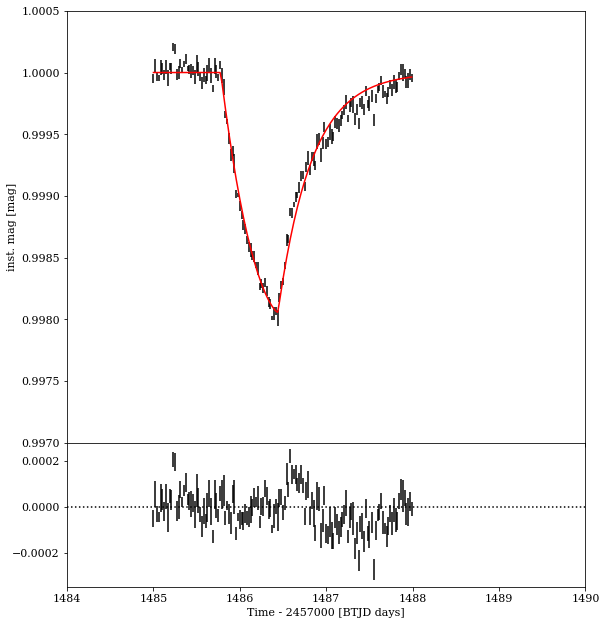

In [178]:
plotfit(result['x'],t,f,ferr)

In [169]:
result

 final_simplex: (array([[1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03],
       [1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
        2.50069581e+03]]), array([338.88041305, 338.88041305, 338.88041305, 338.88041809,
       338.88041809, 338.88041809]))
           fun: 338.88041305110016
       message: 'Optimization terminated successfully.'
          nfev: 917
           nit: 440
        status: 0
       success: True
             x: array([1.48629851e+03, 1.42687746e-02, 4.15998915e-03, 1.02134210e+03,
       2.50069581e+03])